In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pylab as pl
from IPython import display
import random

%matplotlib inline
%load_ext memory_profiler

In [2]:
## Creating a function that will return the RGB values of each node
## @param: np.array of flots
## @return: python list of tuples with contain RGB values
def rgb_Calcs(d):
    rgb_vals = []

    for index in range(len(d)):
        rgb_vals.append( ( 255 - ((d[index] * 255.00) / max(d)),
                          0,
                          ((d[index] * 255.00) / max(d)) ) )
        
    return rgb_vals

Before we star, we will first consider the strucutre of a graph.

Definition: A graph $\mathcal{G}$ is an ordered pair $(\mathcal{e}, \mathcal{v})$ such that $\mathcal{e} \in E$ are a set of edges and $\mathcal{v} \in V$ are a set of verticies (or commonly known as nodes).

Example of an Undirected-Graph:
![Undirected-Graph](https://upload.wikimedia.org/wikipedia/commons/5/5b/6n-graf.svg)


Example of a Direct-Graph:

![Directed-Graph](https://upload.wikimedia.org/wikipedia/commons/1/1c/Directed_graph%2C_cyclic.svg)

<br>
<br>

## Implementation of PageRank:

We first will initialize a graph; the graph model that will be used are the Barbasi-Albert model. The reason for this is that we want to 'simulate' an instance of many websites that point to a a common source. We can think of this common source as 'Wikipedia' for exmaple.

![Barabasi-Albert_](https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Barabasi_albert_graph.svg/1350px-Barabasi_albert_graph.svg.png)


### We create the graph object and then convert it to a matrix in these two lines of code:

In [3]:
## Creates a Barabási–Albert graph
G = nx.barabasi_albert_graph(35,17)

In [4]:
## Converts the nx.graph object to a numpy matrix object (an adjacency matrix)
M = nx.to_numpy_matrix(G)

### Defining the Matrix 

In order to perform PageRank, we need to calculate a matrix, what I call Link_Matrix, which is an ($n$ $x$ $n$) adjacency matrix that will have the following structure:

#### $$L_{ij} = \frac{a_{ij}}{\Sigma_{i=1}^{n}a_{ik}}$$ 

<br>
<br>
What this says is that it divides the current element in the matrix $a_{ij} \in \mathcal{Z}^{2}$ and divide it by the total number of pages that page j points to; i.e. sum of all column elements.

For example: If we are given the following matrix (the undirected graph above),

$$A=
\left(\begin{array}{cc} 
0 & 1 & 0 & 0 & 1 & 0\\
1 & 0 & 1 & 0 & 1 & 0\\
0 & 1 & 0 & 1 & 0 & 0\\
0 & 0 & 1 & 0 & 1 & 1\\
1 & 1 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0\\
\end{array}\right)$$

The L matrix (Link Matrix) is calculated as such:

$$A=
\left(\begin{array}{cc} 
0 & \frac{1}{3} & 0 & 0 & \frac{1}{3} & 0\\
\frac{1}{2} & 0 & \frac{1}{2} & 0 & \frac{1}{3} & 0\\
0 & \frac{1}{3} & 0 & \frac{1}{3} & 0 & 0\\
0 & 0 & \frac{1}{2} & 0 & \frac{1}{3} & 1\\
\frac{1}{2} & \frac{1}{3} & 0 & \frac{1}{3} & 0 & 0\\
0 & 0 & 0 & \frac{1}{3} & 0 & 0\\
\end{array}\right)$$


<br>
<br>
Notice the structure of the matrix; It's a $\mathit{Stochastic \ Matrix}$ or ($\mathit{Markov \ Matrix}$) (All of the columns of the matrix sum up to 1) that has a very important properties:
<br>
- max{$Spec(A)$} $\leq{1}$
<br>
<br>
Proof:
$A$ is a stochastic matrix, therefore the sum of all column in the matrix adds to 1. So $A^{T}$ is a stochastic matrix whose rows all add up 1, therefore it must have a corresponding eigenvector $v$:
<br>
$$v=
\left(\begin{array}{cc} 
1 \\
1 \\
1 \\
1 \\
1 \\
\ldots \\
1 \\
\end{array}\right)$$
<br>

But we know that det($A$) = det($A^{T}$) $\Longrightarrow$ det($A - \lambda I_{n}$) = det($A^{T} - \lambda I_{n}$), thus $A$ and $A^{T}$ must have the same eigenvalues. One of the eigenvalues of $A$ and $A^{T}$ is 1.
<br>
Assume now that $|{\lambda}| > 1$ so as $\Longrightarrow$ $lim_{n \rightarrow \infty} ||A^{n}v||$ = $lim_{n \rightarrow \infty}|\lambda^{n}|\ ||v||$ $\Longrightarrow$ there is a coefficient $[A^{n}]_{ij}$ is larger than 1. But since $A^{n}$ is s stochastic matrix, $\rightarrow \leftarrow$.
<br>
$\therefore$ $spec(A) \leq{1}$
<br>
$\blacksquare$

As a consequence, this says that the $Spectral \ Radius \ \rho(A) \leq{1}$, Since the $\rho(A) \leq{1} \Longrightarrow$ our matrix (i.e. the stochastic mtrix) is convergent when iterating with a vector.
<br>
<br>
The following block of code will calcuate the 'Link Matrix':

In [5]:
## Creating a function that will calculate the L matrix
## @param: nxn np.matrix object
## @return: nxn np.matrix object
def Link_Matrix(M):
    L = np.matrix(np.zeros((M.shape[0], M.shape[0])))
    
    for index in range(M.shape[0]):
        L[:,index] = M[:,index] / np.sum(M[:, index])
        
    return L

### Defining the PageRank vector

Another component that is needed is the initialization of the PR vector. What this vector represents is the 'importance' of each $page_{i}$.
<br>
Note: This vector was not sorted in any way.

$$PR_{intial}=
\left(\begin{array}{cc} 
importance \ of \  P_{1} \\
importance \ of \  P_{2} \\
importance \ of \  P_{3} \\
\ldots \\
importance \ of \  P_{n-1} \\
importance \ of \  P_{n} \\
\end{array}\right)$$
<br>

<br>


To initialize the PR vector, we will assume that all pages are of equal importance, thus we take a column vector of ones and divide it by the total length of the vector.

$$PR_{intial}= \frac{1}{n}
\left(\begin{array}{cc} 
1\\
1\\
1\\
1\\
1\\
1\\
1\\
\ddot\\
\\1
\end{array}\right)$$
<br>


<br>
The two blocks of code will create and display the PR vector, called PR_intial. 

In [6]:
## Initializes the old_PR vector
PR_initial = np.zeros(M.shape[0])[np.newaxis].T

## Creating a loop that will input the 1/n value for each index
for index in range(M.shape[0]):
    PR_initial[index] = float(1 / M.shape[0])

In [7]:
## Displays the old_PR vector
PR_initial

array([[0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143],
       [0.02857143]])

As a side note, we observe in the blocks before that algorithm implementation is very important to assure that 
performance for computation is optimal. The following blocks of code have two implementations:
<br>
1. rank_one explores a clever way to exploit matrix multiplication
2. rank_two explores a more naive approach

In [8]:
def rank_one(M):
    
    Link = Link_Matrix(M)

    temp = Link.dot(PR_initial)

    for index in range(1000):

        rank = Link.dot(temp)

        temp = rank
    
    return rank

In [9]:
def rank_two(M):
    temp = Link_Matrix(M).dot(PR_initial)

    for index in range(1000):

        rank = Link_Matrix(M).dot(temp)

        temp = rank
    
    return rank

In [10]:
## Benchmarks the PageRank algorithm implementaion 
%timeit rank_one(M)

2.59 ms ± 83 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
## Benchmarks the PageRank algorithm implementaion 
%timeit rank_two(M)

1.08 s ± 81.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
## Ratio between the two algorithm implementation
1.13 / 3.15e-3

358.7301587301587

#### We can observe that the more naive implementation is 358.73 fold less efficient than the first approach. The lesson here is that just becuase the algorithm is written logically mathematically, doesn't mean its efficient. 

### Calculation of PageRank
We will define the PageRank matrix as L (Link Matrix), which is a stochastic matrix and the initial PageRank vector PR as defined above. We will take PR and multiply it with L to generate a new PR vector:

$$PR_{New} = L \ PR_{Old}$$
<br>
<br>

##### What does this mean?
<br>
$$PR_{New}=
\left(\begin{array}{cc} 
\diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond \\
\diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond \\
\diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond \\
\diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond \\
\diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond \\
\diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond \\
\diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond \\
\diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond & \diamond \\
\end{array}\right) \left(\begin{array}{cc} 
1\\
1\\
1\\
1\\
1\\
1\\
1\\
1\\
\end{array}\right)$$
<br>
Again, $PR_{New}$ calculates is the PageRank score of node i.
<br> 



<br>
<br>
But this calculation is the first estimate, so what happens if we do it again? We replace $PR_{New}$ with $PR_{Old}$:
<br>
<br>


#### $$PR_{New \ New} = L \ PR_{New} =  L^{2} \ PR_{Old}$$
<br>
We can do this and guaranteed convergence because we have shown above that the Spectral Radius $\rho(A) \leq{1}$
therefore we can apply the $Power \ Method$ to calculate a solution:
<br>
#### $$PR_{New + 1} = L \ PR_{New}$$

###  What does this converge to?
If we kept iterating through (lets say $k = 1000$). We will define the eigenvectors $\eta_{1}$,$\eta_{2}$, $\eta_{3}$, ..., $\eta_{n}$ that correspond to the eigenvalues in descending order $\lambda_{1}$, $\lambda_{2}$, $\lambda_{3}$, ..., $\lambda_{n}$ ( i.e. $\lambda_{1}$ is the largest). With this we can express $PR_{old}$ as linear combination of some constants $c_{i}$ and the eigenvectors $\eta_{i}$:
<br>
#### $$PR_{Old} = c_{1}\eta_{1} + c_{2}\eta_{2} + c_{3}\eta_{3} + ... + c_{n}\eta_{n}$$

#### $$\Longrightarrow \ L^{1000} \ PR_{Old} = c_{1}\lambda^{1000}_{1}\eta_{1} + c_{2}\lambda^{1000}_{2}\eta_{2} + .... + c_{n}\lambda^{1000}_{n}\eta_{n}$$
<br>
<br>
We can observe that the $\mathbf{Principal \ Eigenvector}$  $\eta_{1}$ dominates, therefore all of the indices in $\eta_{1}$ will have rank of the webpages for the rows of the matrix $M$. 
<br>
<br>
<br>

### Demo!

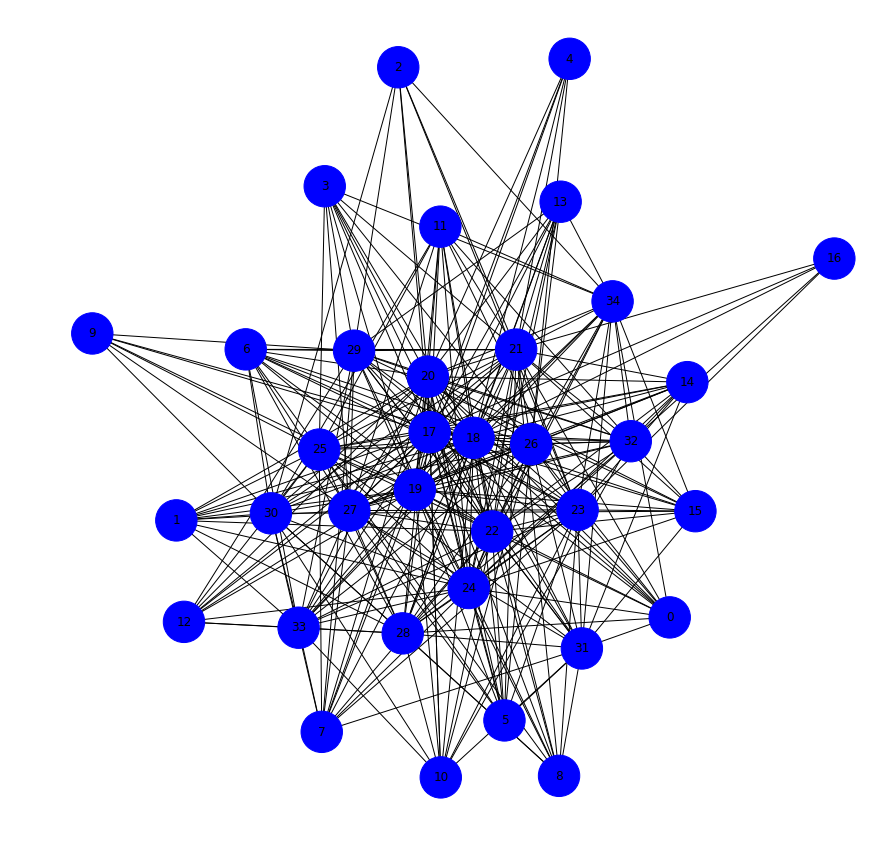

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

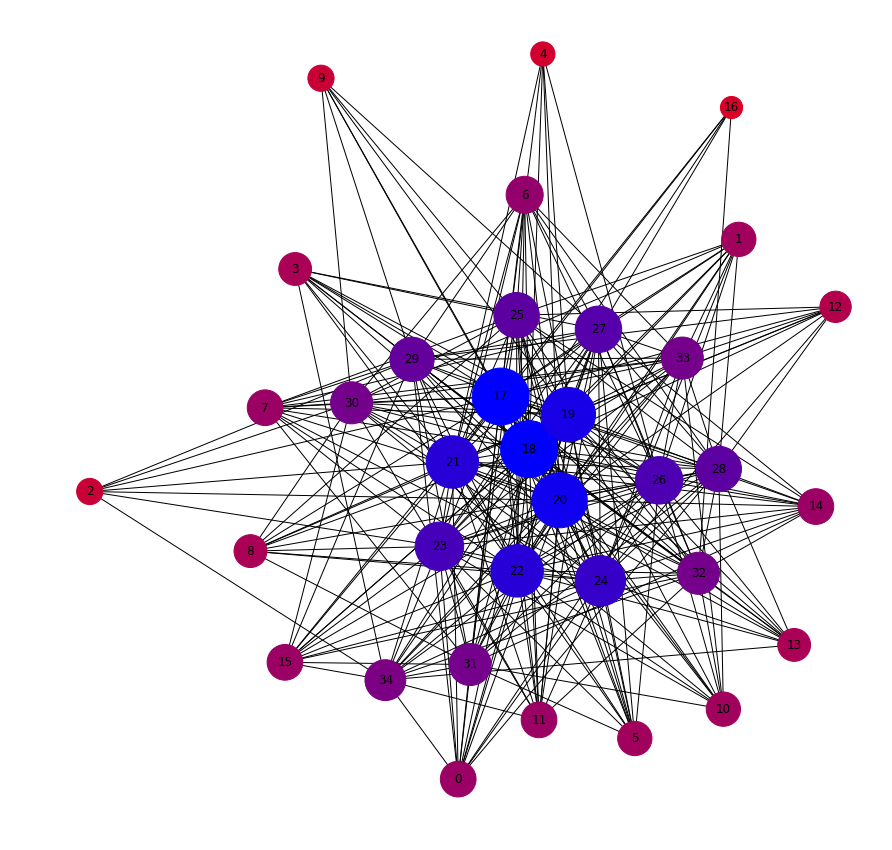

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

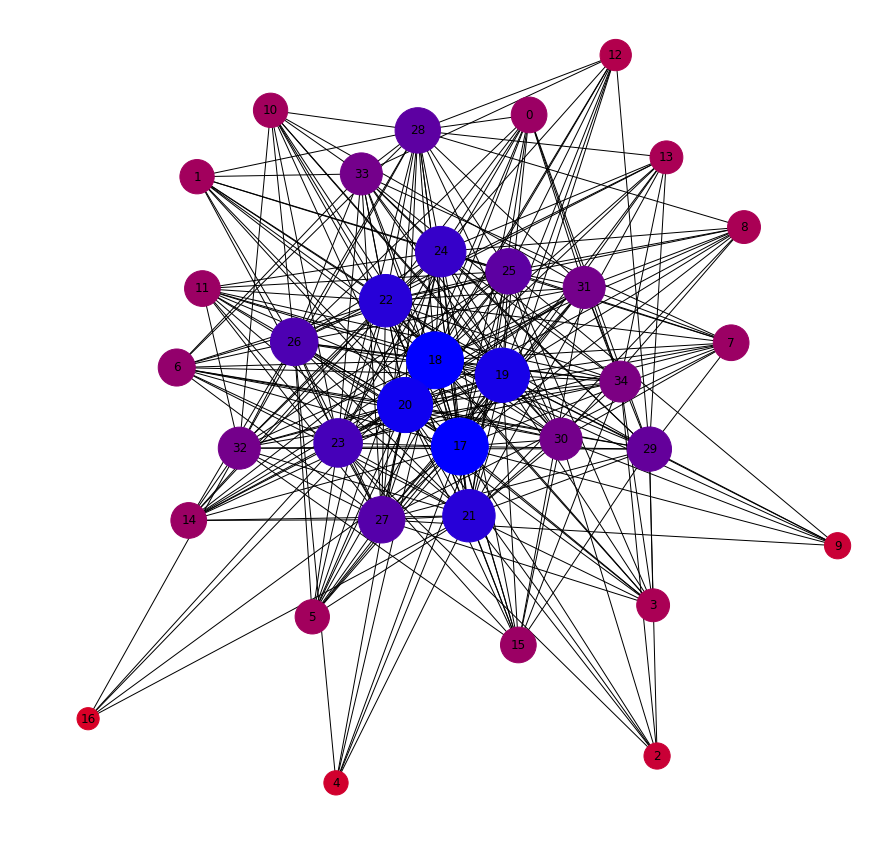

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

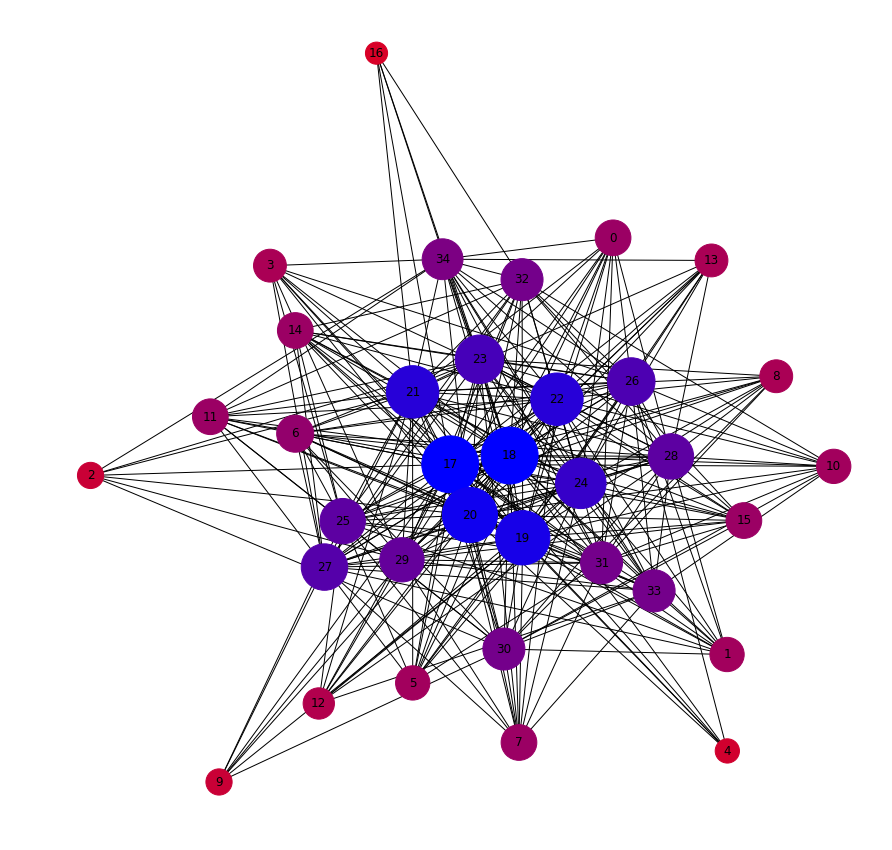

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

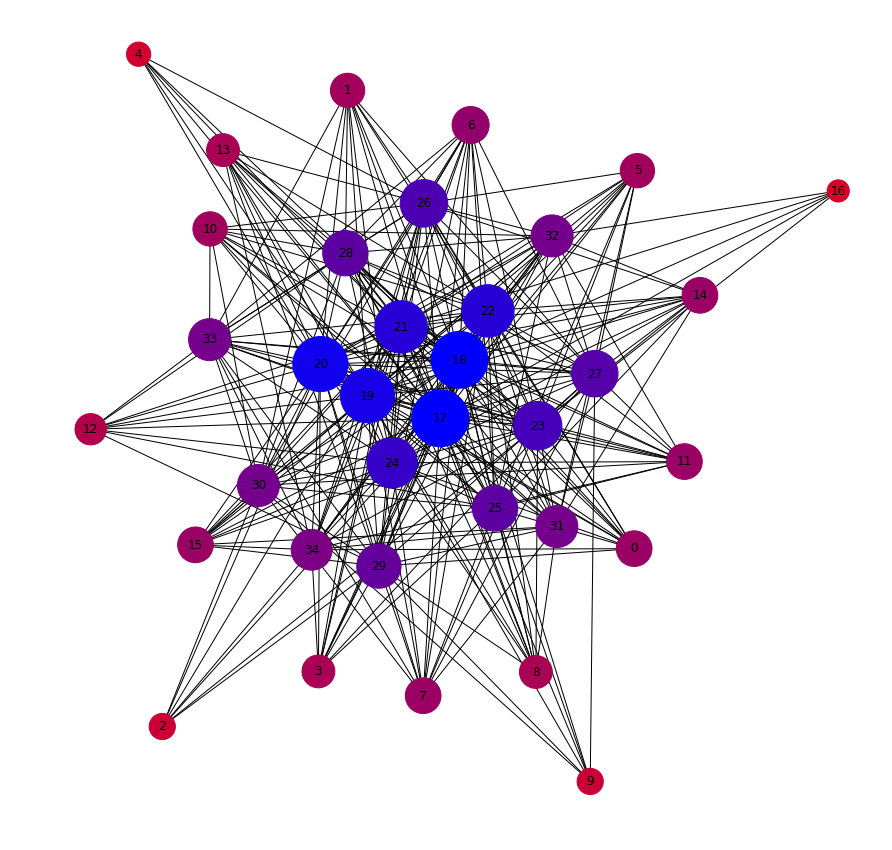

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

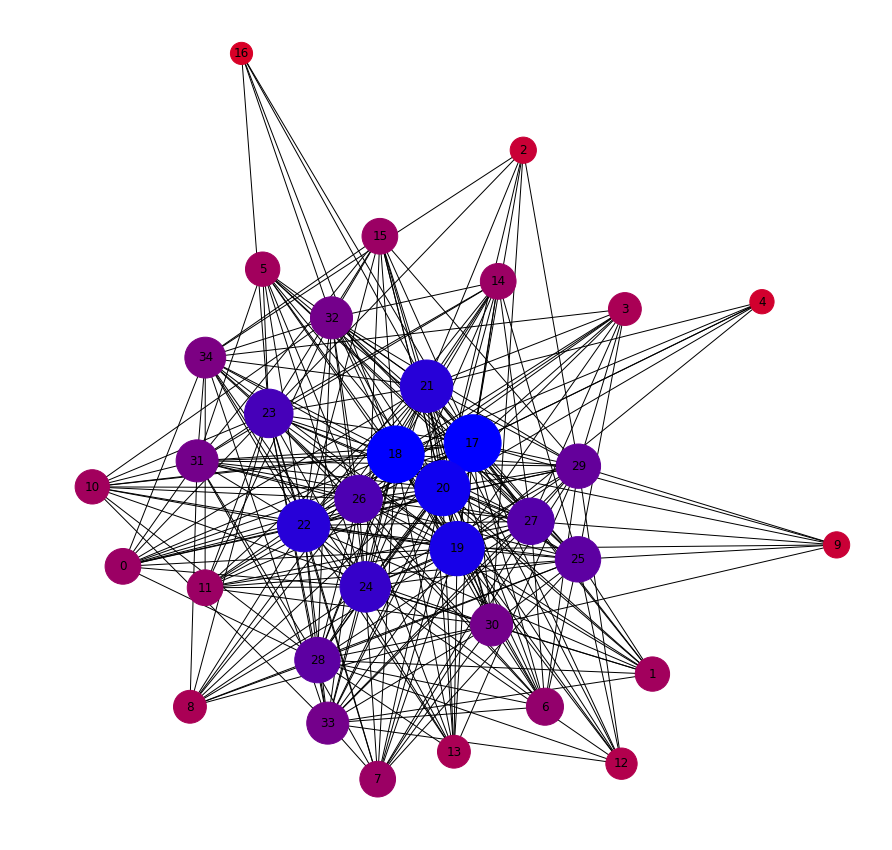

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

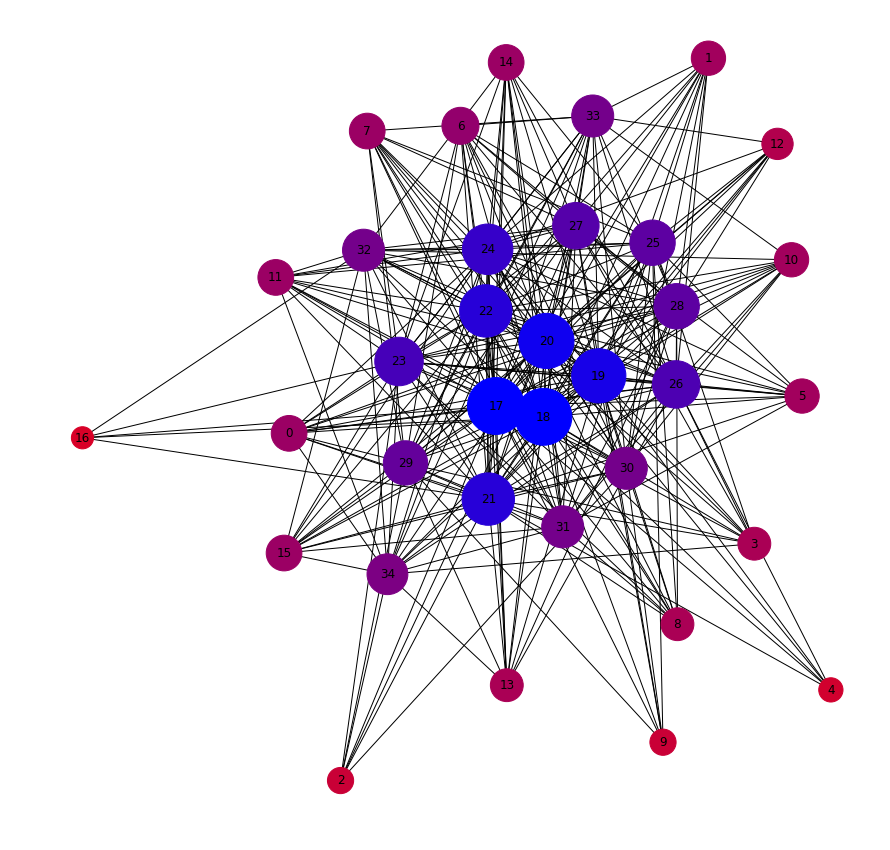

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

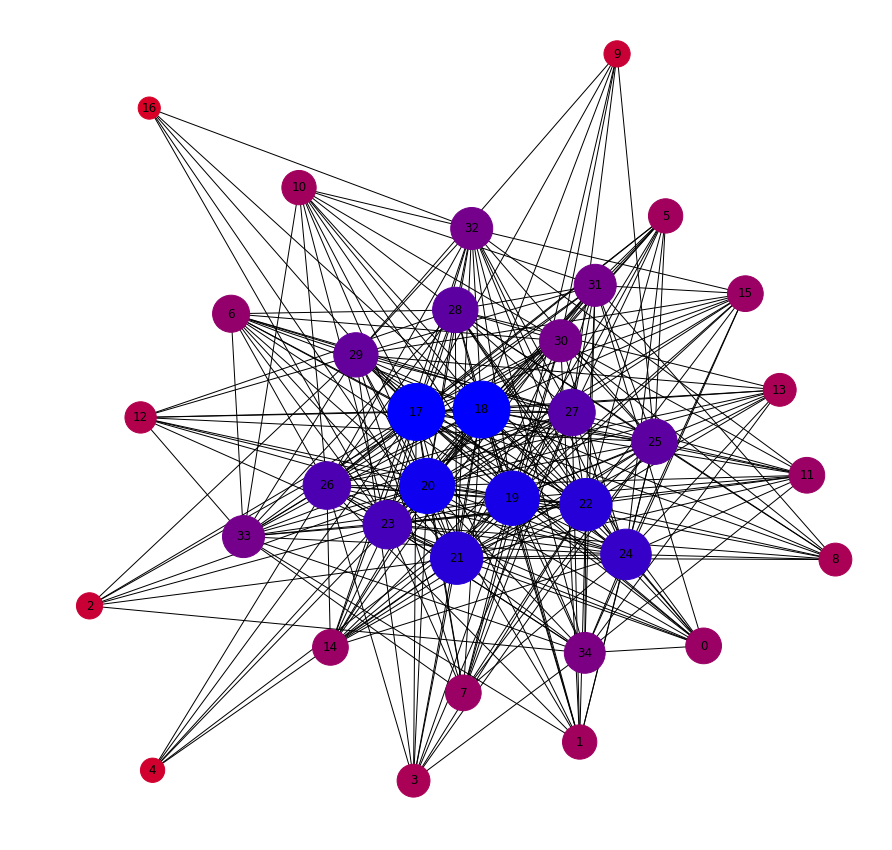

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

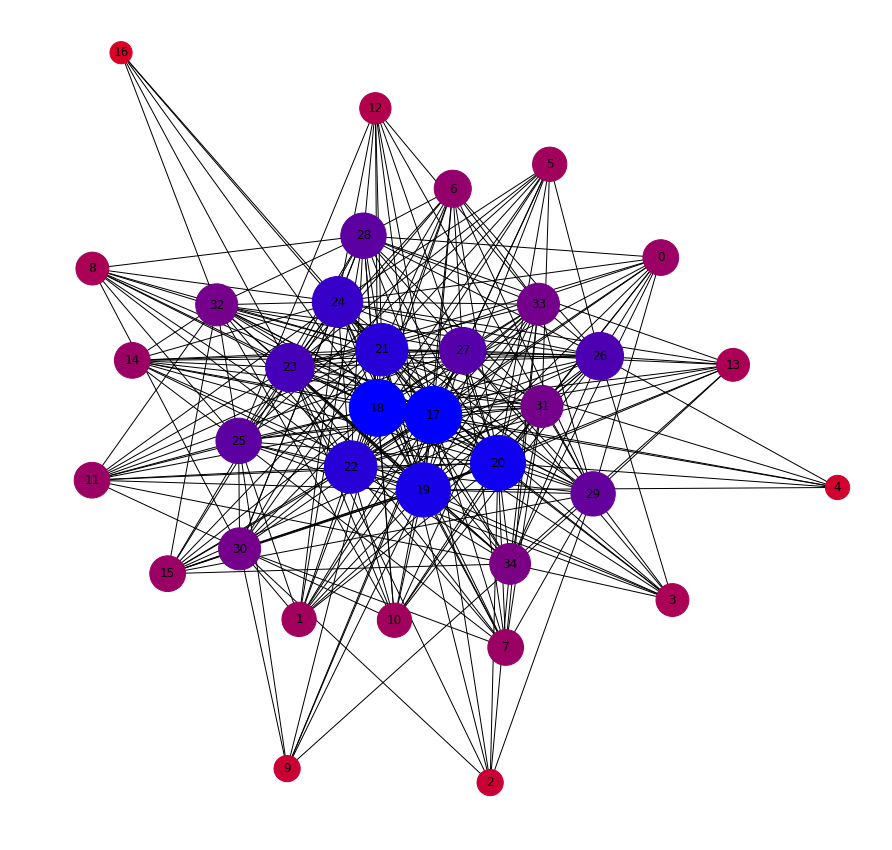

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

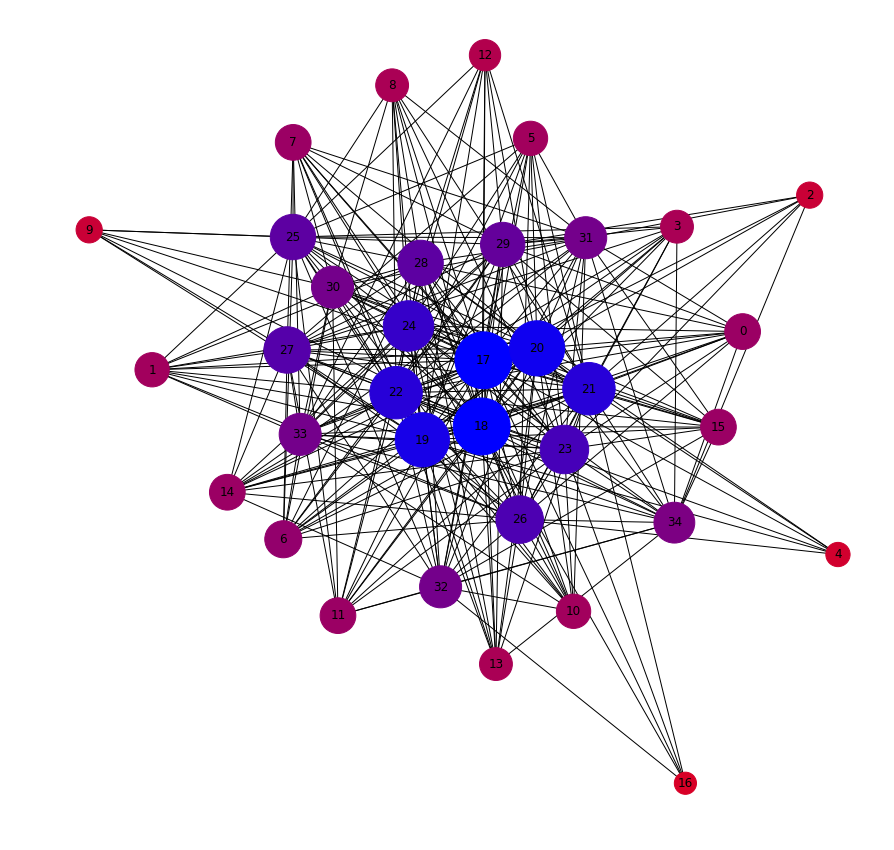

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [13]:
## Creates a temprorary place holder for calculations
PR_Temp = Link_Matrix(M).dot(PR_initial)

plt.figure(figsize = (15,15))
fig = nx.draw_networkx(G, k = 2,node_size = np.array(PR_initial.T) * 60000, center = (0,0), 
                       node_color = np.divide(rgb_Calcs((np.array(PR_initial.T).tolist()[0])), 255) )
plt.axis('off')
plt.show(fig)
display.display(plt.gcf())

for index in range(1,1001):
    PR = Link_Matrix(M).dot(PR_Temp)
    
    if index % 100 == 0:
        
        plt.figure(figsize = (15,15))
        fig = nx.draw_networkx(G,k = 2, node_size = np.array(PR.T) * 60000, center = (0,0),
                               node_color = np.divide(rgb_Calcs((np.array(PR.T).tolist()[0])), 255) )
        plt.axis('off')
        plt.show(fig)
        display.display(plt.gcf())
        
        
    PR_Temp = PR


        
        
plt.figure(figsize = (15,15))
plt.axis('off')
nx.draw_networkx(G,k = 2 ,node_size = np.array(PR.T)* 60000, center = (0,0),
                 node_color = np.divide(rgb_Calcs((np.array(PR.T).tolist()[0])),255) )

In [15]:
## Prints out index where it has the most links pointing to it
np.where(PR == np.max(PR))[0][0]

17

In [16]:
## Prints the vector for index above
M[np.where(PR == np.max(PR))[0][0]]

matrix([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 0.]])

### Q: What is the most popular website that appears when searching information on google? (Neglecting services and goods)

### A: Let's find out

### Applications
There was a paper written $\mathit{David \ Gleich}$ called $\mathit{PageRank \ Beyond \ the \ Web}$ (2015) and in this paper, he explains the different variations of PageRank but, more importantly the applications PageRank is used for. Applications range in Biology, Chemistry, Social Networks, Recommender Systems, Literature, Bibliometrics, and Sports.
<br>
<br>
One application we will explore in depth is Social Network Analysis, in particular partner to be in a romantic relationship.
<br>
<br>
##### Consider the following scenario:
While browsing Tinder (a fantastic way to meet people) you have been matched with 6 people, you then got out on dates with these 6 people over 6 month period. On the $7^{th}$ month, one of the people said that they want to be in an exclusive relationship with you but you can't decide if they are going to be a good fit. Moreover, you don't want to make a mistake and pick the wrong person then regret it later. You panic and call your mathematician friend and ask for relationship advice. Your friend the mathematician says: "Lets apply PageRank to see what traits you most desired from all of these people you have dated."
<br>
You two grab coffee and work through the night generating the right criteria that you want your relationship to be based on. It turns that there are 8 important criteria that $\mathbf{really}$ matter to you: 

Must Haves = {$Attractiveness, \ Communication, \ Intimacy,\ Ambition, \ Trust, \ Intellegence $}
<br>
<br>
Once there is a criteria defined, we can then create a vector of a person that has these criteria as components of that vector where these vectors will contain binary information of a specific 'must have'. The matrix can be then generated by arranging the column vectors into the matrix.
<br>
<br>

$$A=
\left(\begin{array}{cc} 
\diamond & \diamond & \diamond & \diamond & \diamond & \diamond \\
\diamond & \diamond & \diamond & \diamond & \diamond & \diamond \\
\diamond & \diamond & \diamond & \diamond & \diamond & \diamond \\
\diamond & \diamond & \diamond & \diamond & \diamond & \diamond \\
\diamond & \diamond & \diamond & \diamond & \diamond & \diamond \\
\diamond & \diamond & \diamond & \diamond & \diamond & \diamond  \\
\end{array}\right)$$

<br>
We will intialize the Rank vector assuming that all qualities in the relationship are equally weighted.
<br>

$$Rank_{intial}= \frac{1}{6}
\left(\begin{array}{cc} 
1\\
1\\
1\\
1\\
1\\
1\\
\end{array}\right)$$
<br>


In [17]:
Qualities = ['Attractiveness','Communication','Intimacy','Ambition','Trust','Intellegence' ]

In [18]:
Must_Haves = np.matrix(np.random.randint(0,2,(6,6)).tolist())

In [19]:
Must_Haves

matrix([[0, 1, 1, 1, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [1, 1, 0, 0, 1, 1],
        [1, 1, 1, 0, 1, 0],
        [1, 0, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 0]])

In [20]:
G = nx.from_numpy_matrix(Must_Haves)

In [21]:
## Initializes the old_PR vector
Rank_initial = np.zeros(Must_Haves.shape[0])[np.newaxis].T

## Creating a loop that will input the 1/n value for each index
for index in range(Must_Haves.shape[0]):
    Rank_initial[index] = float(1 / Must_Haves.shape[0])

In [22]:
Rank_initial

array([[0.16666667],
       [0.16666667],
       [0.16666667],
       [0.16666667],
       [0.16666667],
       [0.16666667]])

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

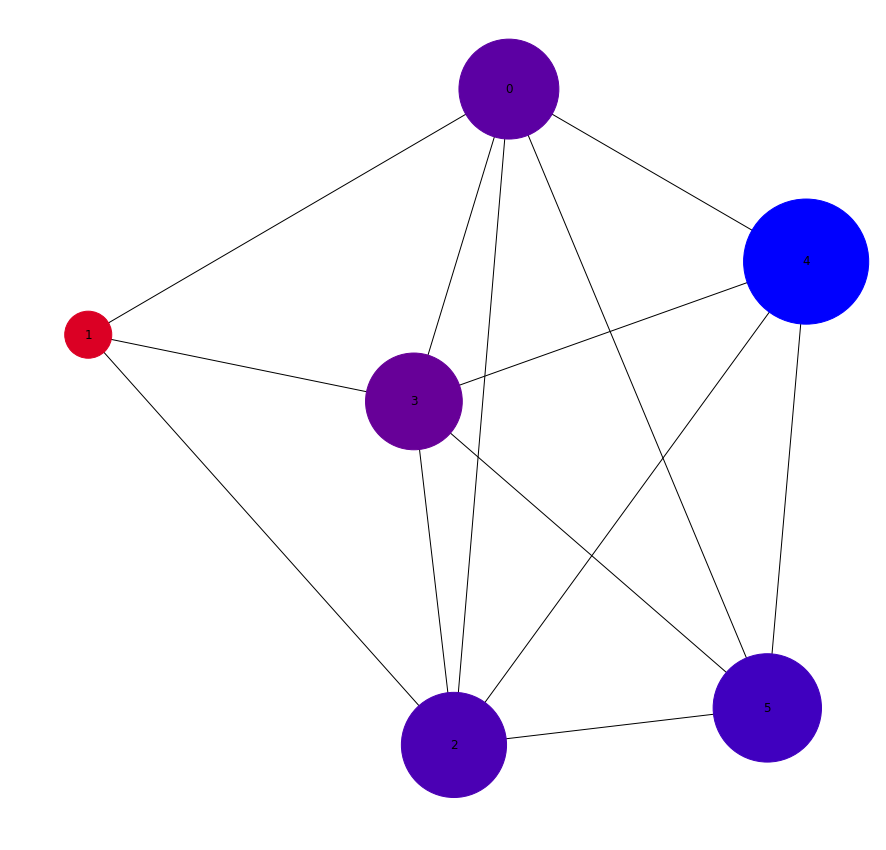

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

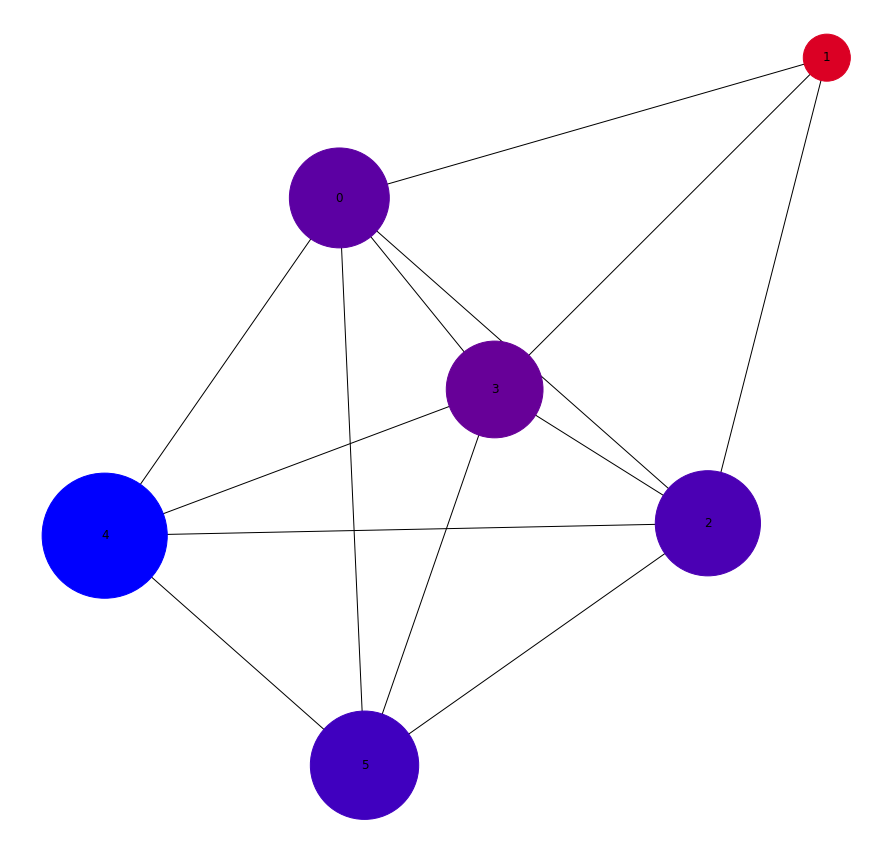

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

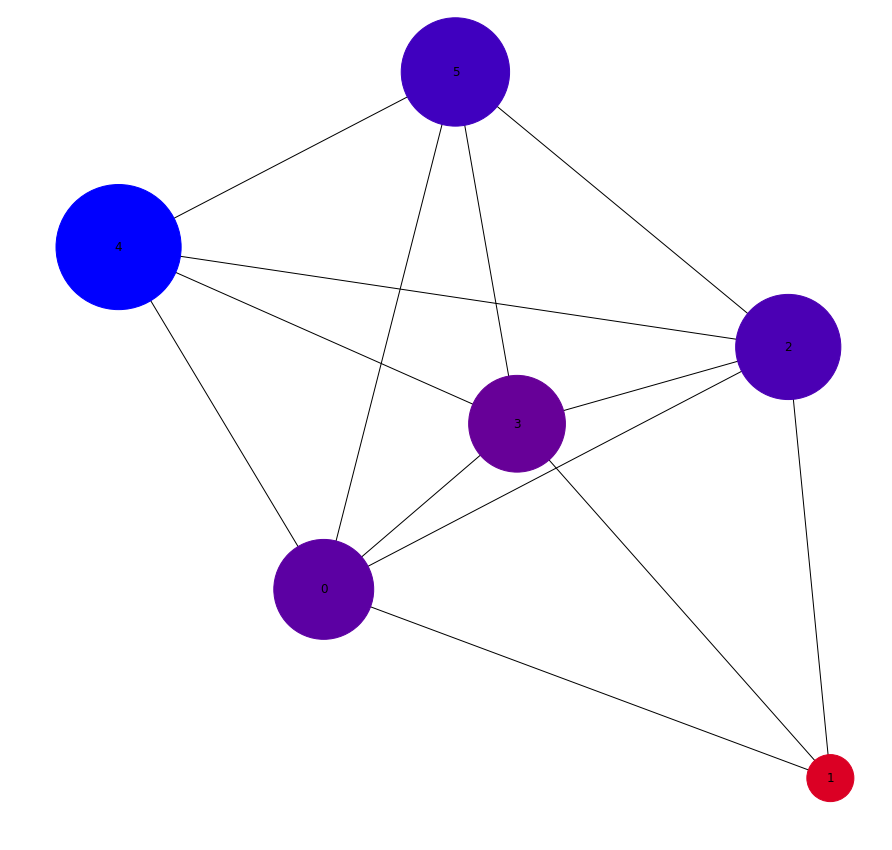

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

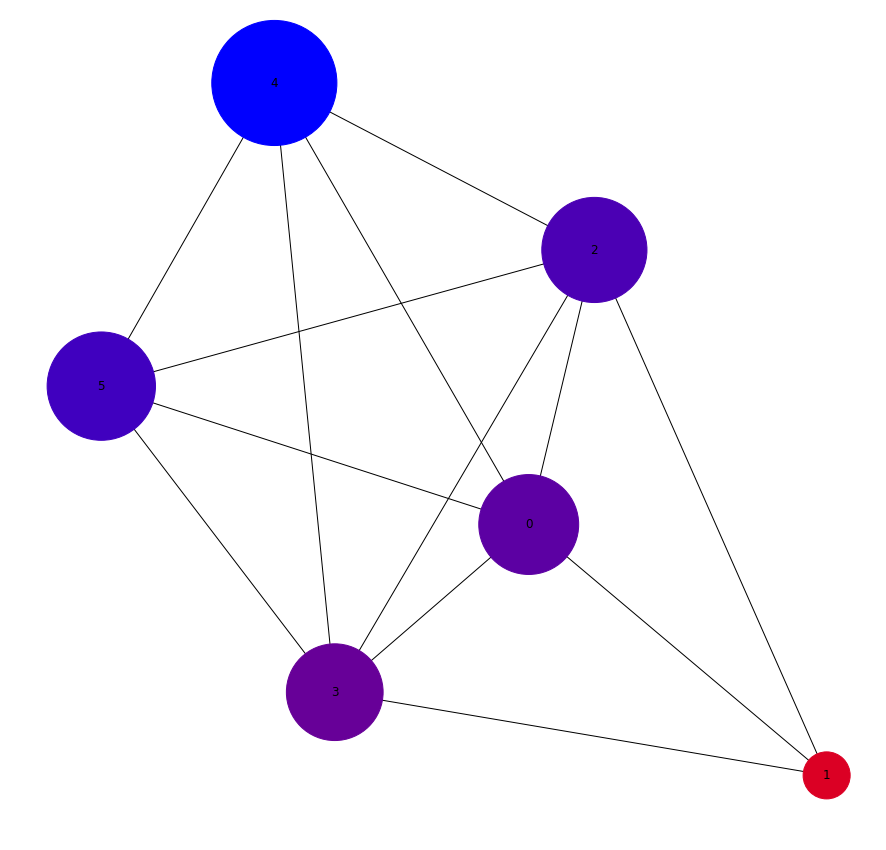

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

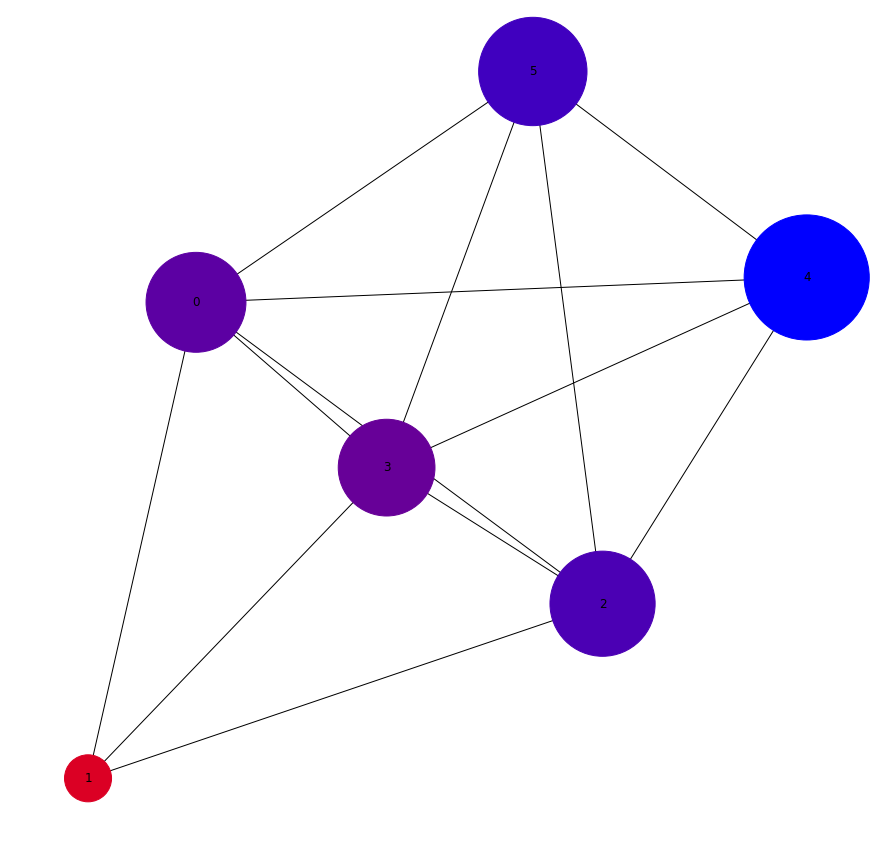

In [23]:
Rank_Temp = Link_Matrix(Must_Haves).dot(Rank_initial)

## Draws the intial state of the graph
plt.figure(figsize = (15,15))
fig = nx.draw_networkx(G, k = 2,node_size = np.array(Rank_initial.T) * 60000, center = (0,0), 
                       node_color = np.divide(rgb_Calcs((np.array(Rank_initial.T).tolist()[0])), 255))
plt.axis('off')
plt.show(fig)
display.display(plt.gcf())

## Creating a loop that will calculate the new Rank vector and draws the associated graph
for index in range(1,1001):

    Rank = Link_Matrix(Must_Haves).dot(Rank_Temp)
    
    if index % 200 == 0:
        
        plt.figure(figsize = (15,15))
        fig = nx.draw_networkx(G,k = 2, node_size = np.array(Rank.T) * 60000, center = (0,0),
                               node_color = np.divide(rgb_Calcs((np.array(Rank.T).tolist()[0])), 255) )
        plt.axis('off')
        plt.show(fig)
        display.display(plt.gcf())
        
        
    Rank_Temp = Rank


        
        
plt.figure(figsize = (15,15))
plt.axis('off')
nx.draw_networkx(G,k = 2 ,node_size = np.array(Rank.T)* 60000, center = (0,0),
                 node_color = np.divide(rgb_Calcs((np.array(Rank.T).tolist()[0])),255) )

In [24]:
## Converts the np.matrix structure to a list structure
Rank_list = []
for line in Rank.tolist():
    Rank_list.append(line[0])

In [25]:
## Prints the percentage of the all qualities one desires in people
print("Quality \t\t Most Desired (%)")
print("-" * 45)
for q, r in zip(Qualities, Rank_list):
    print("{0:<15} \t  {1:3f}%".format(q,r * 100))

Quality 		 Most Desired (%)
---------------------------------------------
Attractiveness  	  16.635161%
Communication   	  3.686200%
Intimacy        	  18.431002%
Ambition        	  15.595463%
Trust           	  26.086957%
Intellegence    	  19.565217%


In [26]:
## Confirms that the vector adds up to 1
np.sum(Rank) * 100

99.99999999999997

In [27]:
if len(np.where(Rank_list == np.max(Rank_list))[0]) == 1:
    print("Most desired quality: {0}".format(Qualities[np.where(Rank_list == np.max(Rank_list))[0][0]]))
    
if len(np.where(Rank_list == np.max(Rank_list))[0]) != 1:
    print("The most desired qualities:")
    print("-" * 26)
    for line in np.where(Rank_list == np.max(Rank_list))[0][0]:
        print(Qualities[line])

Most desired quality: Trust


#### What this tells us is a way to understand what traits we desire the most in people, and out of all of the people that we have relationships with (in this case romantically) we can observe two things:
- We understand ourselves the best, therefore shouldn't be suprised that the results came out the way as expected of us
- We found out something new about ourselves which can then translate to potentially try a new experience